In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from src.models import common_neighbor_community as cnc
from src.data import random_graph as rg
from src.features import max_intersect_accuracy as acc

r_seed = 123

%load_ext autoreload
%autoreload 2

## Big Gap Graph

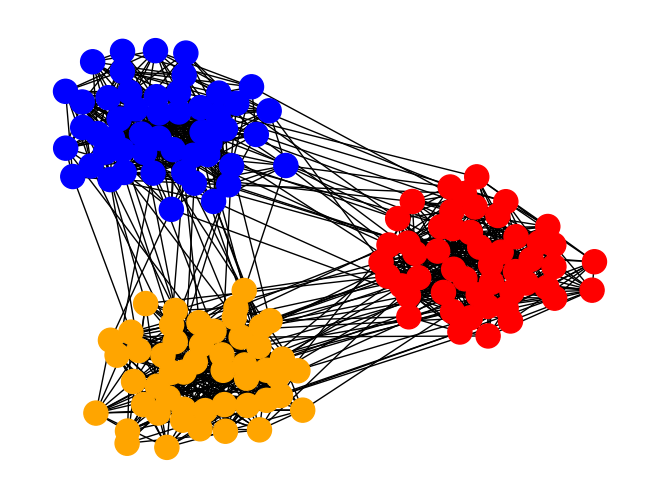

In [2]:
RG = rg.RandomCommunitiesGraph()
G, actual_com = RG.generate_random_com_graph(N=150,
                                            n_groups=3,
                                            p_in_group=0.3,
                                            p_out_group=0.01,
                                            seed=r_seed)

RG.draw(seed=r_seed)

In [3]:
CNC = cnc.CommonNeighborCommunity(G, actual_com)
CNC.findAllCommunities(thres=0.1, weighted=True)
re = CNC.getResult()
re

,pred_com,actual_com
node,,
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
145,2,2
146,2,2
147,2,2


In [4]:
preds = CNC.getPredCommunities()
actual = CNC.getActualCommunities()

acc.computeAccuracies(actual=actual, predictions=preds)


1.0

#### Explore how threshold change affect accuracy

In [5]:
def differentThes(lower_thres, higher_thres, interval, CNC):
    avg_accs = []
    ths = []
    for thres in np.arange(lower_thres, higher_thres, interval):
        CNC.findAllCommunities(thres=thres, weighted=True)
        preds = CNC.getPredCommunities()
        actual = CNC.getActualCommunities()
        
        ths.append(thres)
        avg_accs.append(acc.computeAccuracies(actual, preds))
    
    return pd.DataFrame({"accuracy": avg_accs, "threshold": ths})

In [6]:
def plotThresAcc(df):
    sns.lineplot(data=df, x="threshold", y="accuracy")
    plt.title("Accuracy per Threshold")
    plt.show()
    plt.close()

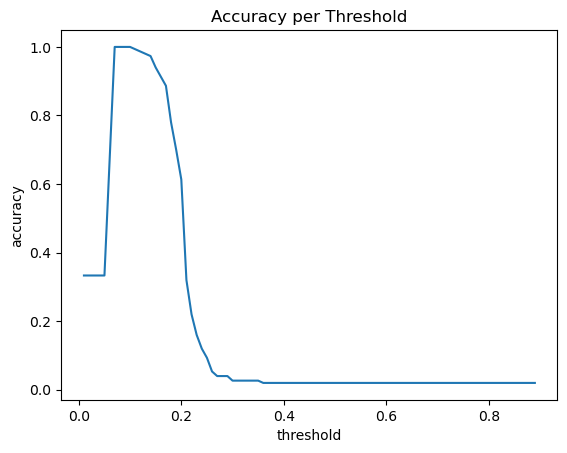

In [7]:
CNC = cnc.CommonNeighborCommunity(G, actual_com)
plotThresAcc(differentThes(0.01, 0.9, 0.01, CNC))

## Small Gap

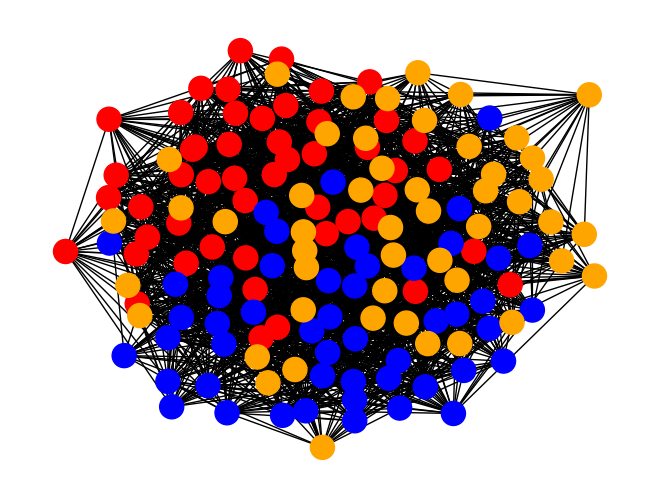

In [8]:
RG = rg.RandomCommunitiesGraph()
G, actual_com = RG.generate_random_com_graph(N=150,
                                            n_groups=3,
                                            p_in_group=0.3,
                                            p_out_group=0.15,
                                            seed=r_seed)

RG.draw(seed=r_seed)

In [9]:
CNC = cnc.CommonNeighborCommunity(G, actual_com)
CNC.findAllCommunities(thres=0.15, weighted=True)
CNC.getResult()

,pred_com,actual_com
node,,
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
145,20,2
146,0,2
147,0,2


In [10]:
preds = CNC.getPredCommunities()
actual = CNC.getActualCommunities()

acc.computeAccuracies(actual=actual, predictions=preds)


0.31333333333333335

#### Find a "best" threshold

#### Let explore from 1% common neighbors to 90%

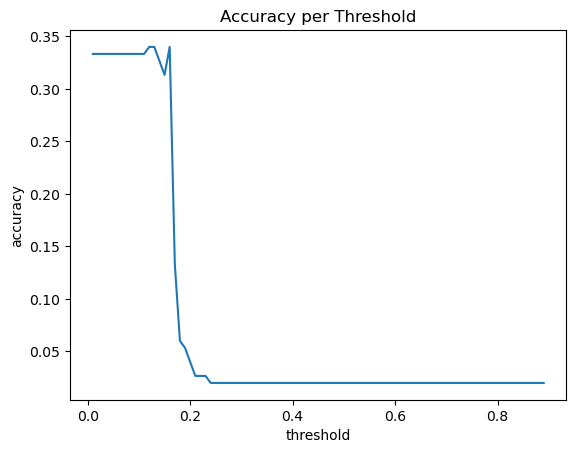

In [11]:
CNC = cnc.CommonNeighborCommunity(G, actual_com)
plotThresAcc(differentThes(0.01, 0.9, 0.01, CNC))


#### Closer look at 1% to 20%


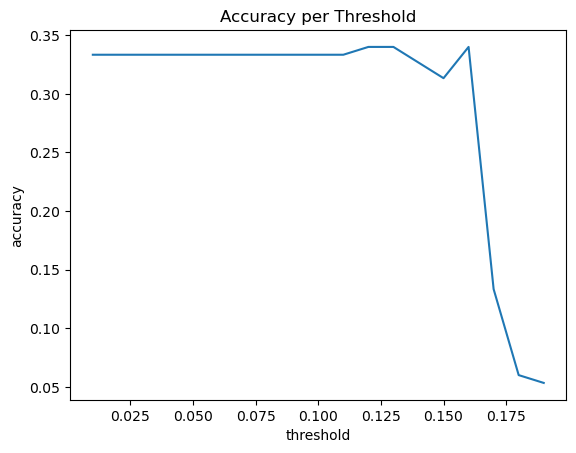

In [12]:
plotThresAcc(differentThes(0.01, 0.2, 0.01, CNC))

## Try relatively large gap

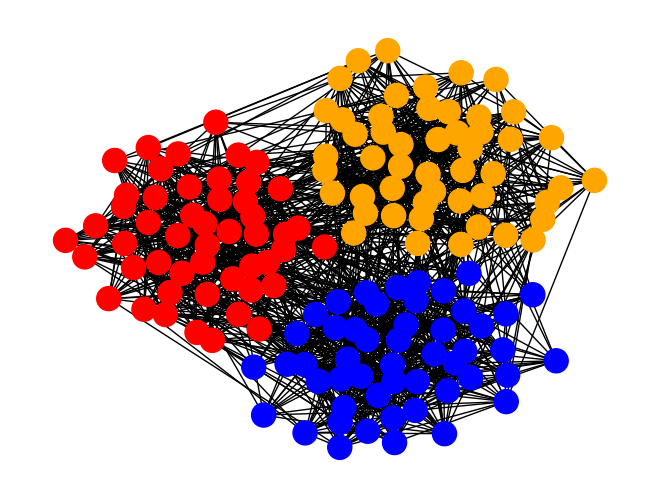

In [13]:
RG = rg.RandomCommunitiesGraph()
G, actual_com = RG.generate_random_com_graph(N=150,
                                            n_groups=3,
                                            p_in_group=0.3,
                                            p_out_group=0.3 - 0.25,
                                            seed=r_seed)

RG.draw(seed=r_seed)

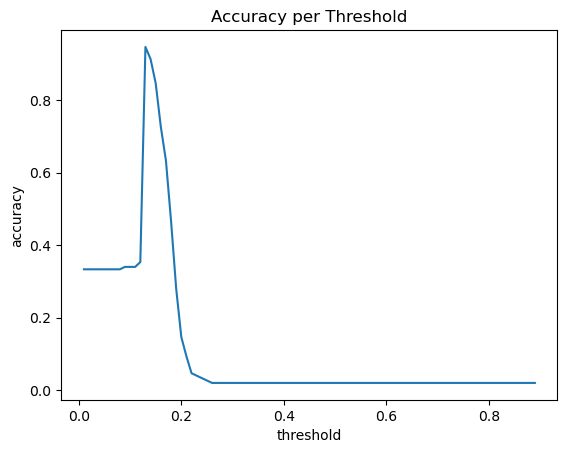

In [14]:
CNC = cnc.CommonNeighborCommunity(G, actual_com)
plotThresAcc(differentThes(0.01, 0.9, 0.01, CNC))

## Try relatively small gap

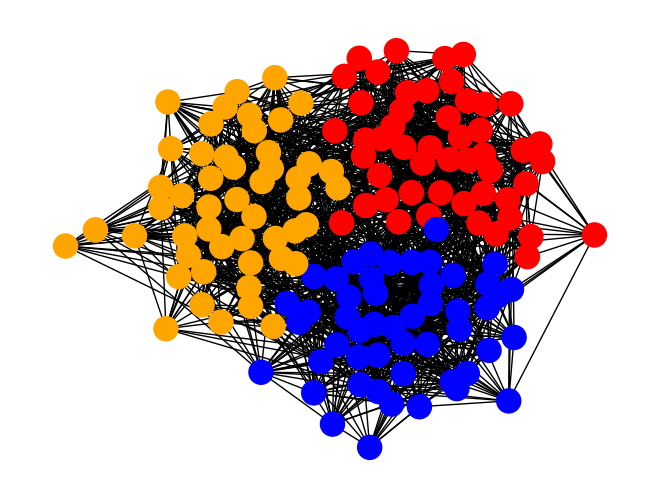

In [15]:
RG = rg.RandomCommunitiesGraph()
G, actual_com = RG.generate_random_com_graph(N=150,
                                            n_groups=3,
                                            p_in_group=0.3,
                                            p_out_group=0.3 - 0.22,
                                            seed=r_seed)

RG.draw(seed=r_seed)

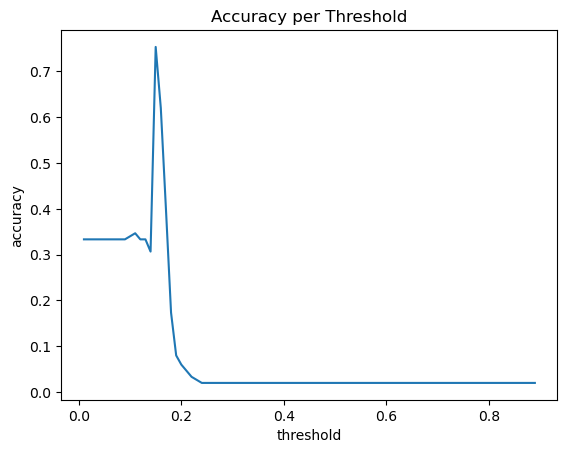

In [16]:
CNC = cnc.CommonNeighborCommunity(G, actual_com)
plotThresAcc(differentThes(0.01, 0.9, 0.01, CNC))

## Fixed in-group probability and threshold, explore how gap change results in min purity change

In [17]:
def findBestThreshold(lower_thres, higher_thres, interval, CNC):
    max_acc = 0.0
    max_thre = None
    
    for thre in np.arange(lower_thres, higher_thres, interval):
        CNC.findAllCommunities(thres=thre, weighted=True)
        actual = CNC.getActualCommunities()
        preds = CNC.getPredCommunities()
        
        ac = acc.computeAccuracies(actual, preds)
        
        if max_acc < ac:
            max_acc = ac
            max_thre = thre
            
    return max_acc, max_thre

In [18]:
def differeentGap(lower_gap, higher_gap, interval):
    accs = []
    gaps = []
    thres = []
    for gap in np.arange(lower_gap, higher_gap, interval):
        p_out = 0.3 - gap
        G, actual_com = RG.generate_random_com_graph(N=150,
                                                    n_groups=3,
                                                    p_in_group=0.3,
                                                    p_out_group=p_out,
                                                    seed=r_seed)
        
        CNC = cnc.CommonNeighborCommunity(G, actual_com)
        
        max_acc, max_thre = findBestThreshold(0.05, 0.30, 0.01, CNC)
        
        accs.append(max_acc)
        gaps.append(gap)
        thres.append(max_thre)
        
    return pd.DataFrame({"accuracy": accs, "gap": gaps, "threshold": thres})

In [19]:
result = differeentGap(0.15, 0.29, 0.01)
result

,accuracy,gap,threshold
0,0.340000,0.15,0.12
1,0.346667,0.16,0.13
2,0.346667,0.17,0.13
3,0.346667,0.18,0.12
4,0.340000,0.19,0.09
5,0.480000,0.20,0.16
6,0.506667,0.21,0.15
7,0.753333,0.22,0.15
8,0.453333,0.23,0.16
9,0.586667,0.24,0.14


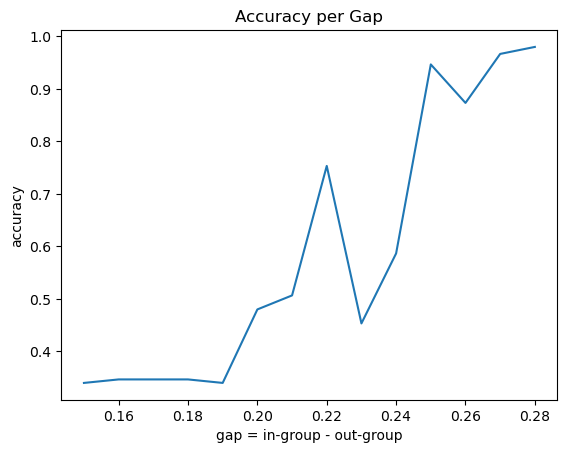

In [20]:

sns.lineplot(data=result, x="gap", y="accuracy")
plt.title("Accuracy per Gap")
plt.xlabel("gap = in-group - out-group")
plt.show()
plt.close()